In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
plt.style.use('ggplot')
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import string
import re
from string import digits
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import demoji
import unidecode

In [8]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CARG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
nlp = spacy.load("es_core_news_sm")
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('spanish')
spanish_stop_words = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CARG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CARG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
df = pd.read_csv(r"C:\Users\CARG\Desktop\Universidad\Analítica para la Inteligencia de Negocios\Segundo_semestre\Topicos avanzados en NLP\Proyecto\Clasificador_topicos\balanceo_1000.csv")

In [11]:
df.head(1)

,topic,text,date_query
0,politica,corte internacional justicia haya colombia tod...,2022-08-30T18:01:55.226Z


In [12]:
#eliminacion de emojis
def clean_text(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'#[A-Za-z0-9]*', ' ', x)
  x = re.sub(r'https*://.*', ' ', x)


  x = re.sub(r'@[A-Za-z0-9]+', ' ', x)

  # remove emojis
  demoji.download_codes()
  x = demoji.replace(x, '')

  # remove accents
  x = unidecode.unidecode(x)

  tokens = word_tokenize(x)
  x = ' '.join([w for w in tokens if not w.lower() in stop_words])
  x = re.sub(r'[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“…”’'), ' ', x)
  x = re.sub(r'\d+', ' ', x)
  x = re.sub(r'\n+', ' ', x)
  x = re.sub(r'\s{2,}', ' ', x)
  return x

In [13]:
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [14]:
df['clean_text'] = df.text.apply(clean_text)
df['lemmatized_text'] = df['clean_text'].apply(lemmatize_text)

C:\Users\CARG\AppData\Local\Temp\ipykernel_16364\3451895952.py:12: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [15]:
df.head()

,topic,text,date_query,clean_text,lemmatized_text
0,politica,corte internacional justicia haya colombia tod...,2022-08-30T18:01:55.226Z,corte internacional justicia colombia todavia ...,corte internacional justicia colombia todavia ...
1,politica,domingo bogotanos vieron dos situaciones disti...,2022-01-17T19:04:23.376Z,domingo bogotanos vieron dos situaciones disti...,domingo bogotano ver dos situación distinto re...
2,politica,comicios año entra hechos escoger autoridades ...,2022-10-29T15:19:18.159Z,comicios ano entra hechos escoger autoridades ...,comicio ano entrar hecho escoger autoridad ter...
3,politica,llamada puerta giratoria permite congresistas ...,2022-12-13T19:33:30.008Z,llamada puerta giratoria permite congresistas ...,llamado puerta giratorio permitir congresista ...
4,politica,después roces ‘tostao’ grupo colombiano choqui...,2020-04-21T16:24:05.033Z,despues roces 'tostao ' grupo colombiano choqu...,despues roce ' tostao ' grupo colombiano choq...


Generacion Labels

In [16]:
unique_labels = df['topic'].unique()
label_mapping = {label: index for index, label in enumerate(unique_labels)}
df['Autor'] = df['topic'].map(label_mapping)

entrenamiento

In [17]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='training accuracy')
    plt.plot(x, val_acc, label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='training loss')
    plt.plot(x, val_loss, label='validation loss')
    plt.title('Loss')
    plt.legend()

In [18]:
X = df['lemmatized_text'].astype(str)
y = tf.keras.utils.to_categorical(df['Autor'], num_classes=df['Autor'].nunique())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Autor'])

In [19]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

In [20]:
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

In [21]:
max_length = len(max(train_seq, key=len))
train_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')
test_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')

In [22]:
class StopTrainOnHighAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        acc_threshold = 0.9
        if logs.get('accuracy') > acc_threshold:
            print(f"\nReached {acc_threshold} accuracy, cancelling training")
            self.model.stop_training = True
def model(vocab_size, max_length):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, 64, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    return model
model = model(vocab_size, max_length)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4166, 64)          6391232   
                                                                 
 bidirectional (Bidirectiona  (None, 4166, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [23]:
history = model.fit(train_vector, y_train, epochs=10, validation_data=(test_vector, y_test), callbacks=[StopTrainOnHighAccuracy()])

Epoch 1/10
150/150 [==============================] - 1427s 9s/step - loss: 1.2890 - accuracy: 0.4675 - val_loss: 0.6413 - val_accuracy: 0.7733
Epoch 2/10
150/150 [==============================] - 1342s 9s/step - loss: 0.5061 - accuracy: 0.8383 - val_loss: 0.5295 - val_accuracy: 0.8167
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.9354
Reached 0.9 accuracy, cancelling training
150/150 [==============================] - 1306s 9s/step - loss: 0.2573 - accuracy: 0.9354 - val_loss: 0.5995 - val_accuracy: 0.8258


In [24]:
loss, accuracy = model.evaluate(train_vector, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(test_vector, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9729
Testing Accuracy:  0.8258


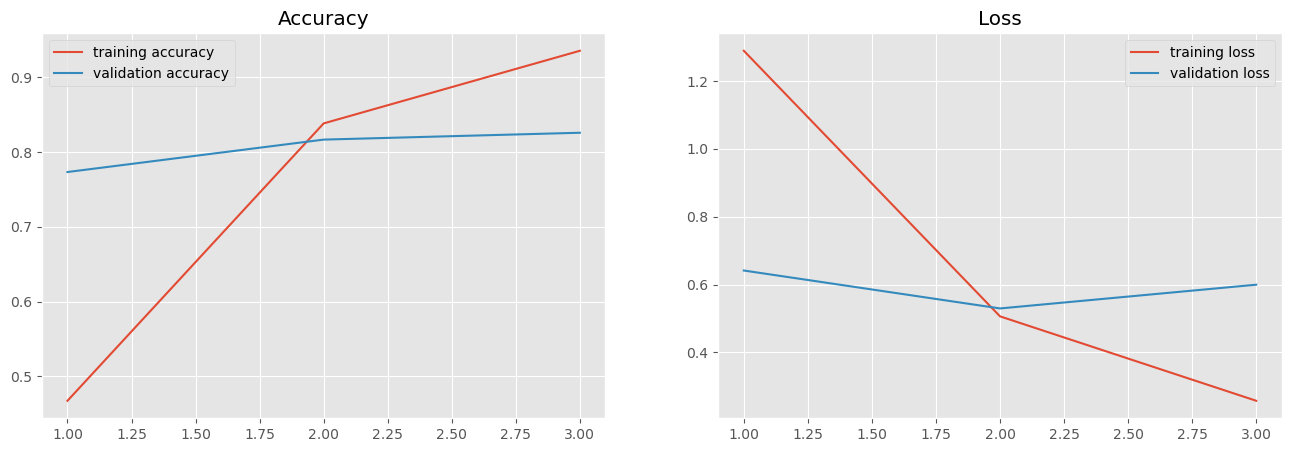

In [25]:
plot_history(history)

In [26]:
predictions = np.argmax(model.predict(test_vector),axis=1)
#(model.predict(test_vector) > 0.5).astype("int32")
ground_truth = np.argmax(y_test, axis=1)

38/38 [==============================] - 51s 1s/step


In [28]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object and fit it to your labels/classes
le = LabelEncoder()
le.fit(ground_truth)  # Assuming ground_truth contains your class labels

# Now you can use 'le' to transform labels/classes


LabelEncoder()

In [29]:
list_precision = []
list_recall = []
list_f1 = []
for precision, target_class in zip(precision_score(ground_truth, predictions, labels=le.transform(le.classes_), average=None), le.classes_):
    list_precision.append({'target' : target_class, 'precision' : precision})

for recall in recall_score(ground_truth, predictions, labels=le.transform(le.classes_), average=None):
    list_recall.append(recall)

for recall in f1_score(ground_truth, predictions, labels=le.transform(le.classes_), average=None):
    list_f1.append(recall)

df_metrics = pd.DataFrame(list_precision)
df_metrics['recall'] = list_recall
df_metrics['f1_score'] = list_f1

In [30]:
df_metrics = round(df_metrics, 2)
df_metrics.sort_values('f1_score', ascending=False)

,target,precision,recall,f1_score
4,4,0.95,1.00,0.97
2,2,0.97,0.88,0.92
0,0,0.88,0.84,0.86
1,1,0.90,0.68,0.78
5,5,0.61,0.88,0.72
3,3,0.78,0.66,0.71


In [31]:
import json
# Guarda el modelo y su tokenizer
model.save('modelo_lstm.h5')

# Guarda el tokenizer en formato JSON
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Guarda el vocabulario del tokenizer en formato JSON
with open('word_index.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.word_index, ensure_ascii=False))